In [1]:


import matplotlib.pyplot as plt
import numpy as np
from qutip import*
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap as lsc
import time
from matplotlib import gridspec
import scipy.optimize as opt
from tcsim.analyze.dataloader import*
from tcsim.analyze.fit_funcs.char_func_fringe import char_func_fringe


# Everything in plae to be able to manipulate it quickly here if  needed.


N = 40
## cavity operators
a = destroy(N)
Ic = qeye(N)
## qubit operator 
def char_func_grid(state, xvec):
    """Calculate the Characteristic function as a 2Dgrid (xvec, xvec) for a given state.

    Args:
        state (Qobject): State of which we want to calc the charfunc
        xvec (_type_): array of displacements. The char func will be calculated for the grid (xvec, xvec)

    Returns:
        tuple(ndarray, ndarray): Re(char func), Im(char func)
    """
    cfReal = np.empty((len(xvec),len(xvec)))
    cfImag = np.empty((len(xvec),len(xvec)))

    for i, alpha_x in enumerate(xvec):
        for j, alpha_p in enumerate(xvec):
            expect_value = expect(displace(N, alpha_x +1j*alpha_p),state)
            cfReal[i,j] =  np.real(expect_value)
            cfImag[i,j] =  np.imag(expect_value)

    return cfReal,cfImag  

def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2


### 1. Load and threshold data

9


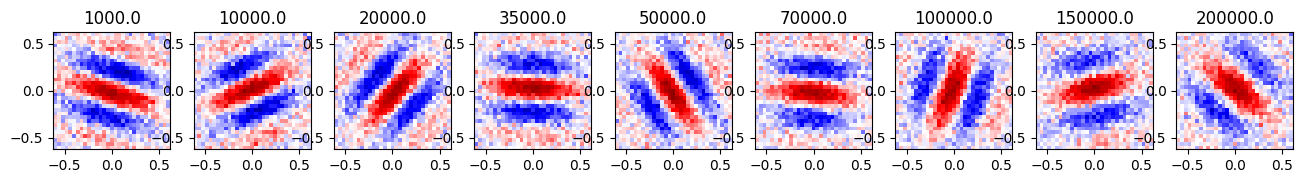

-0.0006451612903225795


In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import os
from scipy import optimize as opt

path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/"
file_end = 'cohstate_decay.h5'
 # load all files
fps = []
fp = [path + f for f in os.listdir(path) if f.endswith(file_end)]
fps = np.concatenate([fp[:]])

data_array = []
dts = []
for kk in range(len(fps)):
#         fname = d + files[kk]
    df = h5py.File(fps[kk], "r")
    data = df["data"]
    x = data["x"][:, 0]
    y = data["y"][0, :]
    data_I = data["I"][:]
    thresh = 0.00015
    data_thresh= np.where(data_I < thresh, 1, -1)
    data_thresh_average = data_thresh.mean(axis=0).reshape((x.shape[0],x.shape[0]))
    
   
    dt = df.attrs['decay_time']
    dts.append(dt)
    data_array.append(data_thresh_average)
print(len(data_array))
decay_times = np.array(dts)


rows = 1
cols = len(decay_times)
X,Y = np.meshgrid(x,y)

fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
# for i in range(rows):
for j in range(cols):
    axes[j].pcolormesh(x, x, data_array[j], cmap="seismic", shading = 'auto', vmin = -1, vmax = 1)
    axes[j].set_aspect("equal")
    axes[j].set_title(str(decay_times[j]))
#         l += 1      
plt.show()
print(data_array[3][:,-1].mean())

### 2. Fit coherent stat fringes to extrct original amp and angles 

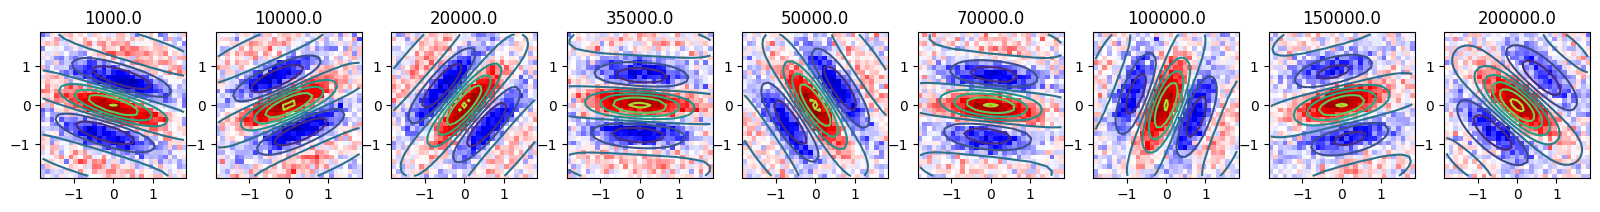

In [3]:
fig, axs = plt.subplots(1, len(data_array), figsize = (20, 20*len(data_array)))

amps = []
angles = []
angles_guess = [0.2+np.pi/2, 0, 0 ,np.pi/2 ,np.pi/2 ,np.pi/2 ,0 ,np.pi/2 ,0]
for i, data in enumerate(data_array):
    scaling = 3
    xvec = x*scaling # i define it like this in case i want to slice x
    yvec = x*scaling
    X, Y = np.meshgrid(yvec, xvec)

    #               amplitude, sigma_x,sigma_y, beta_amp, theta, offset)
    initial_guess = (2,  1, 1, 1, angles_guess[i], 0) # upper blob

        
    popt, pcov = opt.curve_fit(char_func_fringe, (X, Y), data.flatten(), p0=initial_guess)
    amps.append(popt[-3])
    angles.append(popt[-2])

    data_fitted1 = char_func_fringe((X, Y), *popt)

    axs[i].pcolormesh(X,Y, data, cmap="seismic", shading = 'auto', vmin = -1, vmax = 1)
    axs[i].contour(yvec,xvec, data_fitted1.reshape(X.shape))
    axs[i].set_aspect("equal")
    axs[i].set_title(str(decay_times[i]))
plt.show()

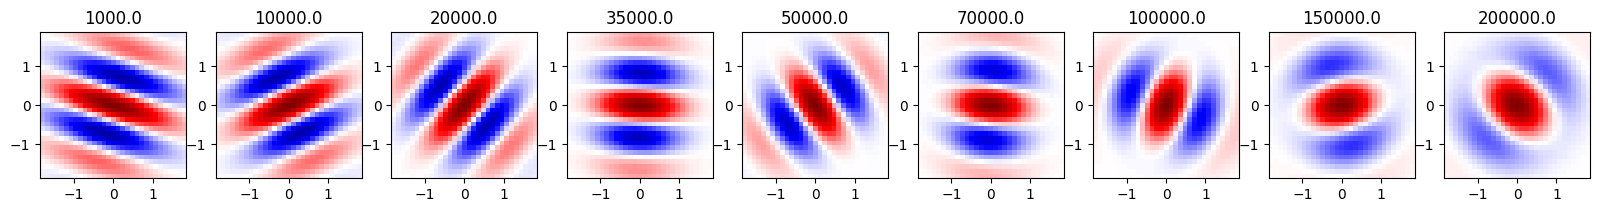

In [4]:
from scipy import optimize
# create states with correct angles
psis = []
for angle in angles:
    psis.append(coherent(N,2*np.exp(1j*angle)))

# sent states through decay
 # send all states through a lossy channel, decaying for the appropriate amount of time
t1 = 250
t2 = 1500
gamma_a_loss = 1 / t1
gamma_a_daphasing = 1 / t2

a_loss = np.sqrt(gamma_a_loss) * a
a_dephasing = np.sqrt(gamma_a_daphasing) * (a * a.dag() + a.dag() * a)
loss = [a_loss,a_dephasing]

rhos = []
for i, psi in enumerate(psis):
    t_list = np.linspace(0, decay_times[i]*1e-3,3)
    rho = mesolve(Ic, psi, tlist=t_list,  c_ops = loss, options=Options(nsteps=5000)).states[-1]
    rhos.append(rho)

char_funcs = []
for rho in rhos:
        char_func, im = char_func_grid(rho,xvec)
        char_funcs.append(char_func) 

fig, axs = plt.subplots(1, len(char_funcs), figsize = (20, 20*len(char_funcs)))
for i in range(len(data_array)):

    axs[i].pcolormesh(X,Y, char_funcs[i], cmap="seismic", shading = 'auto', vmin = -1, vmax = 1)
    axs[i].set_aspect("equal")
    axs[i].set_title(str(decay_times[i]))
    

In [5]:
from scipy import optimize
# create states with correct angles
psis = []
for angle in angles:
    psis.append(coherent(N,2*np.exp(1j*angle)))

# sent states through decay
 # send all states through a lossy channel, decaying for the appropriate amount of time

    


def calc_overlap(t2):
    t2 = t2[0]
    # send all states through a lossy channel, decaying for the appropriate amount of time
    gamma_a_loss = 1 / 250
    gamma_a_daphasing = 1 / t2

    a_loss = np.sqrt(gamma_a_loss) * a
    a_dephasing = np.sqrt(gamma_a_daphasing) * (a * a.dag() + a.dag() * a)
    loss = [a_loss,a_dephasing]
    rhos = []
    for i, psi in enumerate(psis):
        t_list = np.linspace(0, decay_times[i]*1e-3,10)
        rho = mesolve(Ic, psi, tlist=t_list, c_ops=loss).states[-1]
        rhos.append(rho)
        
    # create char_func_grids for all states
    
    char_funcs = []
    for rho in rhos:
        char_func, im = char_func_grid(rho,xvec)
        char_funcs.append(char_func)
    
    fidelity = 0
    for j, char_func in enumerate(char_funcs):
        fidelity += np.sum((char_func-data_array[j])**2)
        
    return fidelity, char_funcs

    
    
    

In [174]:
fid, char_funcs = calc_overlap([2000])

In [176]:
char_funcs[0]

array([[-3.39215458e-02, -3.85584708e-02, -4.19516416e-02,
        -4.33600783e-02, -4.20189822e-02, -3.72235395e-02,
        -2.84254159e-02, -1.53300380e-02,  2.01993997e-03,
         2.31900724e-02,  4.73413129e-02,  7.32668451e-02,
         9.94793474e-02,  1.24341405e-01,  1.46224202e-01,
         1.63674058e-01,  1.75564090e-01,  1.81209750e-01,
         1.80432290e-01,  1.73562118e-01,  1.61383304e-01,
         1.45029263e-01,  1.25846366e-01,  1.05245783e-01,
         8.45638293e-02,  6.49477270e-02,  4.72780609e-02,
         3.21323970e-02,  1.97880369e-02,  1.02566862e-02,
         3.34064799e-03],
       [-2.77937251e-02, -2.75950881e-02, -2.47157717e-02,
        -1.83987026e-02, -7.99583315e-03,  6.92606167e-03,
         2.64822238e-02,  5.03858272e-02,  7.78996930e-02,
         1.07837718e-01,  1.38624025e-01,  1.68409530e-01,
         1.95236162e-01,  2.17230238e-01,  2.32800076e-01,
         2.40810525e-01,  2.40709209e-01,  2.32585983e-01,
         2.17157024e-01,  1.95

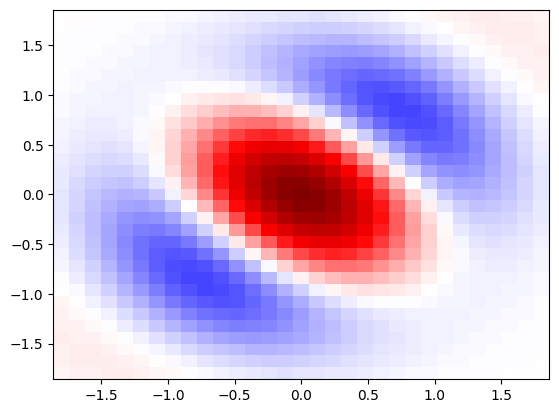

In [178]:
plt.pcolormesh(xvec, xvec, char_funcs[8], vmin = -1, vmax = 1, cmap="seismic")

In [6]:
T2 = np.linspace(200,5000,75)
fids = []
for time in T2:
    fids.append(calc_overlap([time]))

c:\Users\jonat\AppData\Local\pypoetry\Cache\virtualenvs\tcsim-vg60nFMD-py3.9\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: x and y must have same first dimension, but have shapes (1,) and (75, 2)

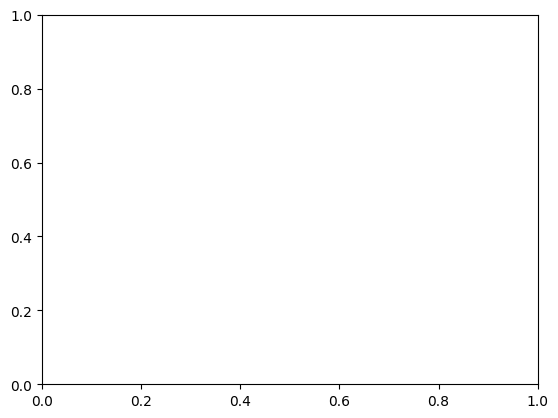

In [7]:
plt.plot(t2,fids)

In [156]:
from scipy import optimize
result = optimize.minimize(calc_overlap, np.array([600]), method="Nelder-Mead")
if result.success:
    fitted_params = result.x
    print(fitted_params)

[2370.]


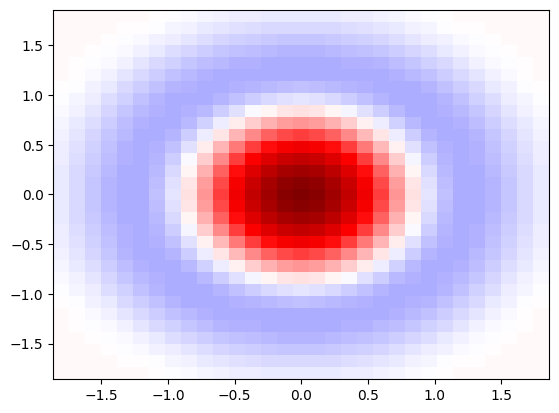

In [138]:

plt.pcolormesh(xvec, xvec, char_funcs[8], vmin = -1, vmax = 1, cmap="seismic")

0.88